In [333]:
using Revise
using DynamicsAndControl
using StaticArrays
using Rotations
using OrdinaryDiffEq
using LinearAlgebra
using Plots
gr()

Plots.GRBackend()

In [277]:
@dynamics PlanarRocketLanding{T} begin
    @integrable begin
        r::SVector{2, T} 
        v::SVector{2, T}
        θ::T
        ω::T
        m::T
    end

    @direct begin
        landed::Bool
    end
end

PlanarRocketLanding

In [278]:
@controller RocketLandingController{T} begin
    @outputs begin
        δ_gim::T
        T_thrust::T
    end
end

RocketLandingController

In [279]:
function DynamicsAndControl.initialize(::Type{PlanarRocketLanding}, config)
    x0 = config.x0

    return (x0.r, x0.v, x0.θ, x0.ω, x0.m), (false,), config.params
end

In [313]:
function DynamicsAndControl.dynamics!(this::PlanarRocketLanding, ẋ, x, u, t)
    @unpack Isp, J, t_hat_body, g0, r_gim2cg = static(this)
    @unpack r, v, θ, ω, m, landed = x
    @unpack δ_gim, T_thrust = u

    f_thrust = T_thrust*RotMatrix(θ)*t_hat_body
    f_grav = SA[0.0, -m*g0]
    f_total = f_thrust + f_grav
    
    if !landed
        ẋ.r = v
        ẋ.v = f_total/m
        ẋ.θ = ω
        ẋ.ω = T_thrust*sin(δ_gim)*r_gim2cg/J
        ẋ.m = -T_thrust/(Isp*g0)
    else
        ẋ.r = ẋ.v = SA[0.0, 0.0]
        ẋ.θ = ẋ.ω = ẋ.m = 0.0
    end

    log!(this, :state, t, (a=ẋ.v, ω̇=ẋ.ω, ṁ=ẋ.m, r, v, θ, ω, m))
    log!(this, :forces, t, (;f_thrust, f_grav, f_total))
end

function DynamicsAndControl.update!(this::PlanarRocketLanding, ẋ, x, u, t)
    if(x.r[2] <= 0.0)
        x.landed = true
        x.v = SA[0.0, 0.0]
        x.ω = 0.0
        return true
    end
    
    return false
end

In [281]:
DynamicsAndControl.initialize(::Type{RocketLandingController}, config) = (), (0.0, 0.0), config

In [296]:
function DynamicsAndControl.update!(this::RocketLandingController, u, _, x, t)
    @unpack v, θ, ω, m = x
    @unpack Kp, Kd, T_W, g0, J, r_gim2cg = static(this)

    T_thrust = m*g0*T_W
    
    axial_des = -v/norm(v)
    axial_cur = RotMatrix(θ)*SA[1.0, 0.0]
    θ_error = -cross(axial_des, axial_cur)
    ω_error = 0.0 - ω
    ω̇_des = Kp*θ_error + Kd*ω_error
    δ_gim = ω̇_des*J/(T_thrust*r_gim2cg)

    @pack! u = T_thrust, δ_gim

    log!(this, :outputs, t, (;T_thrust, δ_gim))
    log!(this, :desired, t, (;ω̇_des, axial_des, axial_cur, θ_error, ω_error))
end

In [283]:
dynamics_conf = ( 
    x0 = (
         r = SA[1288.5705974409814, 2001.7550218991737],
         v = SA[-174.99312755562536, -171.84482593257277],
         θ = 45*π/180,
         ω = .3*π/180,
         m = 17941.58360388262,
         #r = SA[0.0, 10.0], 
         #v = SA[-.2, -6.0],
         #θ = 89.0*π/180,
         #ω = .1*π/180,
         #m = 15.6e3,
    ),
    params = (
        Isp = 300,
        g0 = 9.81,
        J = 5e6,
        r_gim2cg = 15.0,
        t_hat_body = SA[1.0, 0.0]
    )
)

(x0 = (r = [1288.5705974409814, 2001.7550218991737], v = [-174.99312755562536, -171.84482593257277], θ = 0.7853981633974483, ω = 0.005235987755982988, m = 17941.58360388262), params = (Isp = 300, g0 = 9.81, J = 5.0e6, r_gim2cg = 15.0, t_hat_body = [1.0, 0.0]))

In [315]:
control_conf = (
    T_W = 2.1, g0 = 9.81, Kp = 6.0, Kd = 3.0, 
    J=dynamics_conf.params.J, r_gim2cg=dynamics_conf.params.r_gim2cg
)

(T_W = 2.1, g0 = 9.81, Kp = 6.0, Kd = 3.0, J = 5.0e6, r_gim2cg = 15.0)

In [321]:
sim = Simulation(
    ( :truth, PlanarRocketLanding, dynamics_conf ),
    ( :controller, RocketLandingController, control_conf ),
    40.0, RK4(), dt=0.01, control_dt=0.02
)

Simulation with dt=0.01, tspan=(0.0, 40.0), solver=RK4, components=
	dynamics: PlanarRocketLanding
	sensor: DynamicsAndControl.FullStateSensor
	controller: RocketLandingController
	actuator: DynamicsAndControl.PassthroughActuator


In [326]:
data = simulate(sim)

Simulation data set with immediate namespaces:
	[:truth, :controller]


In [348]:
function truth_plot(data)
    s = data.truth.state
    f = data.truth.forces

    plot(
        plot(s.r[1], s.r[2], xlabel="downrange [m]", ylabel="altitude [m]", label=false),
        plot(s.time, s.θ.*180/π, xlabel="time [s]", ylabel="attitude [deg]", label=false),
        plot(s.time, s.v, xlabel="time [s]", ylabel="velocity [m/s]", label=["vx" "vz"]),
        plot(s.v[2], s.r[2], xlabel="v down [m/s]", ylabel="altitude [m]", label=false),
        plot(s.time, s.ω.*180/π, xlabel="time [s]", ylabel="body rate [dps]", label=false),
        plot(s.time, s.m, xlabel="time [s]", ylabel="mass [kg]", label=false),
        size=(900, 600), layout=@layout([ a{0.5w} [grid(2,2); b{0.2h}  ] ])
    )
end

truth_plot (generic function with 1 method)

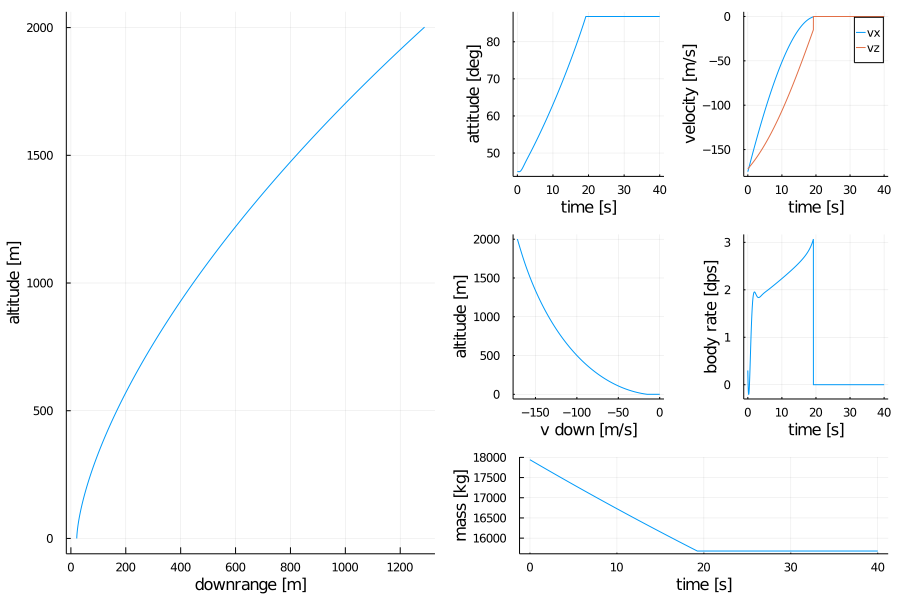

In [349]:
truth_plot(data)

In [363]:
function control_plot(data)
    o = data.controller.outputs
    d = data.controller.desired

    plot(
        plot(d.time, d.θ_error.*180/π, xlabel="time [s]", ylabel="att error [deg]", label=false),
        plot(d.time, d.ω_error.*180/π, xlabel="time [s]", ylabel="rate error [dps]", label=false),
        plot(o.time, o.δ_gim.*180/π, xlabel="time [s]", ylabel="gimbal [deg]", label=false),
        plot(o.time, o.T_thrust, xlabel="time [s]", ylabel="thrust [N]", label=false),
        plot(d.time, d.ω̇_des.*180/π, xlabel="time [s]", ylabel="wdot des [dpss]", label=false),
        size=(900, 600), layout=@layout([grid(2,1){0.5w} [b; c; d]])
    )
end

control_plot (generic function with 1 method)

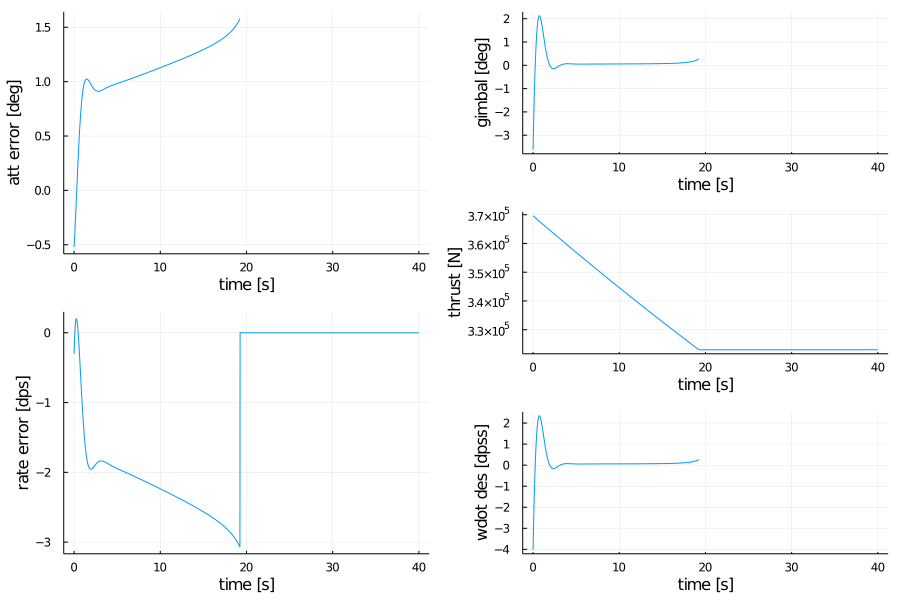

In [364]:
control_plot(data)